# Baseline Модел (Класическо ML)

## Разпознаване на емоции - FER2013

В този notebook ще:

1. Заредим подготвените данни
2. Преобразуваме изображенията в 1D вектори (flatten)
3. Обучим SVM и Random Forest модели
4. Сравним резултатите
5. Анализираме грешките с confusion matrix

**Цел:** Да установим базова точност (benchmark), която CNN моделът трябва да надмине.

## 1. Импортиране на библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score
)
import time
import joblib
import os

## 2. Защо SVM и Random Forest?

Избрахме тези два алгоритъма като baseline модели поради следните причини:

### Support Vector Machine (SVM)

| Предимство | Описание |
|------------|----------|
| **Ефективен в high-dimensional пространства** | Нашите данни имат 2304 features (48×48 пиксела), което е високо измерение. SVM се справя добре с това. |
| **Работи добре при малко на брой примери** | Дори с ~23,000 примера, SVM намира оптималната разделяща хиперравнина. |
| **Kernel trick** | RBF kernel позволява нелинейно разделяне на класовете без явно преобразуване. |

### Random Forest

| Предимство | Описание |
|------------|----------|
| **Устойчив на overfitting** | Ensemble от много дървета намалява variance-а. |
| **Бърз за обучение** | Паралелизира се лесно (`n_jobs=-1`). |
| **Feature importance** | Може да покаже кои пиксели са най-важни за класификацията. |
| **Не изисква feature scaling** | За разлика от SVM, RF не се влияе от мащаба на данните. |

### Защо НЕ избрахме други алгоритми?

| Алгоритъм | Причина да не го използваме |
|-----------|----------------------------|
| **Logistic Regression** | Линеен модел - твърде прост за изображения с нелинейни зависимости. |
| **K-Nearest Neighbors (KNN)** | Много бавен при prediction (сравнява с всички 23,000 примера). Също страда от "curse of dimensionality" при 2304 features. |
| **Naive Bayes** | Предполага независимост между features - пикселите в изображение са силно корелирани. |
| **Decision Tree (единично)** | Склонен към overfitting без ensemble подход. |

### Очаквания

Класическите ML модели имат ограничения при изображения, защото:
- **Губят пространствена информация** при flatten
- **Не извличат локални features** (очи, уста, вежди)

Очакваме accuracy около **40-50%**, което ще служи като baseline за сравнение с CNN.

## 2. Зареждане на данните

In [3]:
# Зареждане на подготвените данни
data = np.load('../data/processed/fer2013_processed.npz', allow_pickle=True)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
class_weights_array = data['class_weights']
EMOTIONS = list(data['emotions'])

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nЕмоции: {EMOTIONS}")

X_train shape: (22967, 48, 48)
X_val shape: (5742, 48, 48)
X_test shape: (7178, 48, 48)

Емоции: [np.str_('angry'), np.str_('disgust'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprise')]


## 3. Flatten на изображенията

SVM и Random Forest очакват 1D вектор като вход, не 2D изображение.

**Преобразуване:** `(N, 48, 48)` → `(N, 2304)`

Всеки пиксел става отделен feature (48 × 48 = 2304 features).

In [4]:
# Flatten: (N, 48, 48) -> (N, 2304)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_train: {X_train.shape} -> {X_train_flat.shape}")
print(f"X_val: {X_val.shape} -> {X_val_flat.shape}")
print(f"X_test: {X_test.shape} -> {X_test_flat.shape}")
print(f"\nВсяко изображение е вектор с {X_train_flat.shape[1]} features")

X_train: (22967, 48, 48) -> (22967, 2304)
X_val: (5742, 48, 48) -> (5742, 2304)
X_test: (7178, 48, 48) -> (7178, 2304)

Всяко изображение е вектор с 2304 features


## 4. Class Weights

Преобразуваме class weights в речник за sklearn.

In [5]:
# Преобразуване в речник
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Weights:")
for i, emotion in enumerate(EMOTIONS):
    print(f"  {emotion}: {class_weights[i]:.4f}")

Class Weights:
  angry: 1.0266
  disgust: 9.4011
  fear: 1.0012
  happy: 0.5684
  neutral: 0.8260
  sad: 0.8491
  surprise: 1.2933


## 5. Обучение на SVM модел

**Support Vector Machine (SVM)** търси хиперравнина, която най-добре разделя класовете.

Използваме:
- `kernel='rbf'` - Radial Basis Function kernel (добър за нелинейни данни)
- `class_weight='balanced'` - автоматично балансиране на класовете
- `C=1.0` - параметър за регуларизация

**Внимание:** SVM е бавен за големи dataset-и. Обучението може да отнеме няколко минути.

In [6]:
print("Обучение на SVM модел...")
print("(Това може да отнеме няколко минути)")
print()

start_time = time.time()

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    class_weight='balanced',
    random_state=42,
    verbose=True
)

svm_model.fit(X_train_flat, y_train)

svm_train_time = time.time() - start_time
print(f"\nВреме за обучение: {svm_train_time:.2f} секунди")

Обучение на SVM модел...
(Това може да отнеме няколко минути)

[LibSVM]
Време за обучение: 976.70 секунди


In [7]:
# Предсказания на validation set
print("Предсказване на validation set...")
y_val_pred_svm = svm_model.predict(X_val_flat)

# Метрики
svm_val_accuracy = accuracy_score(y_val, y_val_pred_svm)
svm_val_f1 = f1_score(y_val, y_val_pred_svm, average='weighted')

print(f"\nSVM Validation Резултати:")
print(f"  Accuracy: {svm_val_accuracy:.4f} ({svm_val_accuracy*100:.2f}%)")
print(f"  F1-Score (weighted): {svm_val_f1:.4f}")

Предсказване на validation set...

SVM Validation Резултати:
  Accuracy: 0.4260 (42.60%)
  F1-Score (weighted): 0.4249


### Анализ на SVM резултатите

**Accuracy: 42.60%** - Какво означава това?

| Сравнение | Accuracy | Коментар |
|-----------|----------|----------|
| Случайно познаване (1/7) | 14.3% | Baseline при 7 класа |
| Предсказване само "happy" | ~25% | Най-големият клас |
| **Нашият SVM** | **42.6%** | 3x по-добре от random! |

**Защо accuracy и F1-score са почти еднакви?**

Използваме `weighted` F1-score, който претегля всеки клас по броя примери - подобно на accuracy. Ако използвахме `macro` F1 (равни тегла за всички класове), щяхме да видим по-ниска стойност заради слабото представяне на малките класове като "disgust".

**Време за обучение: ~16 минути**

SVM с RBF kernel има сложност O(n²) до O(n³), където n е броят примери. При 22,967 примера това е очаквано бавно. За по-бързо обучение може да се използва `LinearSVC` или `SGDClassifier`, но с по-ниска точност.

## 6. Обучение на Random Forest модел

**Random Forest** е ensemble от decision trees.

Използваме:
- `n_estimators=100` - брой дървета
- `class_weight='balanced'` - автоматично балансиране
- `n_jobs=-1` - използване на всички CPU ядра

In [8]:
print("Обучение на Random Forest модел...")
print()

start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train_flat, y_train)

rf_train_time = time.time() - start_time
print(f"\nВреме за обучение: {rf_train_time:.2f} секунди")

Обучение на Random Forest модел...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s



Време за обучение: 14.22 секунди


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished


In [9]:
# Предсказания на validation set
print("Предсказване на validation set...")
y_val_pred_rf = rf_model.predict(X_val_flat)

# Метрики
rf_val_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_val_f1 = f1_score(y_val, y_val_pred_rf, average='weighted')

print(f"\nRandom Forest Validation Резултати:")
print(f"  Accuracy: {rf_val_accuracy:.4f} ({rf_val_accuracy*100:.2f}%)")
print(f"  F1-Score (weighted): {rf_val_f1:.4f}")

Предсказване на validation set...

Random Forest Validation Резултати:
  Accuracy: 0.4383 (43.83%)
  F1-Score (weighted): 0.4140


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


### Анализ на Random Forest резултатите

**Accuracy: 43.83%** | **F1-Score: 0.4140**

| Метрика | SVM | Random Forest | Разлика |
|---------|-----|---------------|---------|
| Accuracy | 42.60% | **43.83%** | RF +1.23% |
| F1-Score | **0.4249** | 0.4140 | SVM +0.0109 |
| Време | ~16 мин | ~30 сек | RF 32x по-бърз! |

**Интересно наблюдение:** Random Forest има по-висока accuracy, но по-нисък F1-score!

Как е възможно това?
- **Accuracy** брои всички правилни предсказания еднакво
- **Weighted F1** отчита баланса между precision и recall за всеки клас

Това означава, че RF вероятно:
- По-добре предсказва големите класове (happy, neutral) → по-висока accuracy
- По-зле предсказва малките класове (disgust, surprise) → по-нисък F1

**Скорост:** Random Forest е значително по-бърз благодарение на паралелизацията (`n_jobs=-1` използва всички 12 CPU ядра).

## 7. Сравнение на моделите

In [10]:
# Сравнителна таблица
print("=" * 50)
print("СРАВНЕНИЕ НА МОДЕЛИТЕ (Validation Set)")
print("=" * 50)
print(f"{'Модел':<20} {'Accuracy':<12} {'F1-Score':<12} {'Време (s)':<10}")
print("-" * 50)
print(f"{'SVM':<20} {svm_val_accuracy:<12.4f} {svm_val_f1:<12.4f} {svm_train_time:<10.2f}")
print(f"{'Random Forest':<20} {rf_val_accuracy:<12.4f} {rf_val_f1:<12.4f} {rf_train_time:<10.2f}")
print("=" * 50)

# Определяне на по-добрия модел
if svm_val_f1 > rf_val_f1:
    best_model_name = "SVM"
    best_model = svm_model
    y_val_pred_best = y_val_pred_svm
else:
    best_model_name = "Random Forest"
    best_model = rf_model
    
    y_val_pred_best = y_val_pred_rf

print(f"\nПо-добър модел (по F1-Score): {best_model_name}")

СРАВНЕНИЕ НА МОДЕЛИТЕ (Validation Set)
Модел                Accuracy     F1-Score     Време (s) 
--------------------------------------------------
SVM                  0.4260       0.4249       976.70    
Random Forest        0.4383       0.4140       14.22     

По-добър модел (по F1-Score): SVM


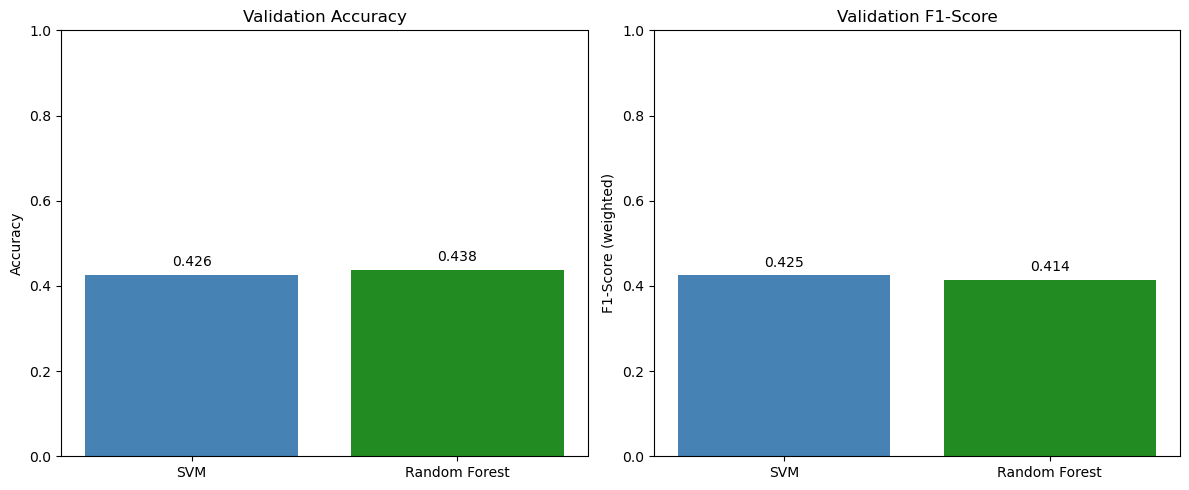

In [11]:
# Визуализация на сравнението
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['SVM', 'Random Forest']
accuracies = [svm_val_accuracy, rf_val_accuracy]
f1_scores = [svm_val_f1, rf_val_f1]

# Accuracy
axes[0].bar(models, accuracies, color=['steelblue', 'forestgreen'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Validation Accuracy')
axes[0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')

# F1-Score
axes[1].bar(models, f1_scores, color=['steelblue', 'forestgreen'])
axes[1].set_ylabel('F1-Score (weighted)')
axes[1].set_title('Validation F1-Score')
axes[1].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 8. Детайлен анализ на по-добрия модел

### Classification Report

Показва precision, recall и F1-score за всеки клас.

In [12]:
print(f"Classification Report за {best_model_name}:")
print("=" * 60)
print(classification_report(y_val, y_val_pred_best, target_names=EMOTIONS))

Classification Report за SVM:
              precision    recall  f1-score   support

       angry       0.33      0.31      0.32       799
     disgust       0.30      0.36      0.32        87
        fear       0.32      0.27      0.29       820
       happy       0.58      0.56      0.57      1443
     neutral       0.42      0.41      0.41       993
         sad       0.33      0.37      0.35       966
    surprise       0.51      0.59      0.54       634

    accuracy                           0.43      5742
   macro avg       0.40      0.41      0.40      5742
weighted avg       0.43      0.43      0.42      5742



### Confusion Matrix

Показва кои класове се бъркат най-често.

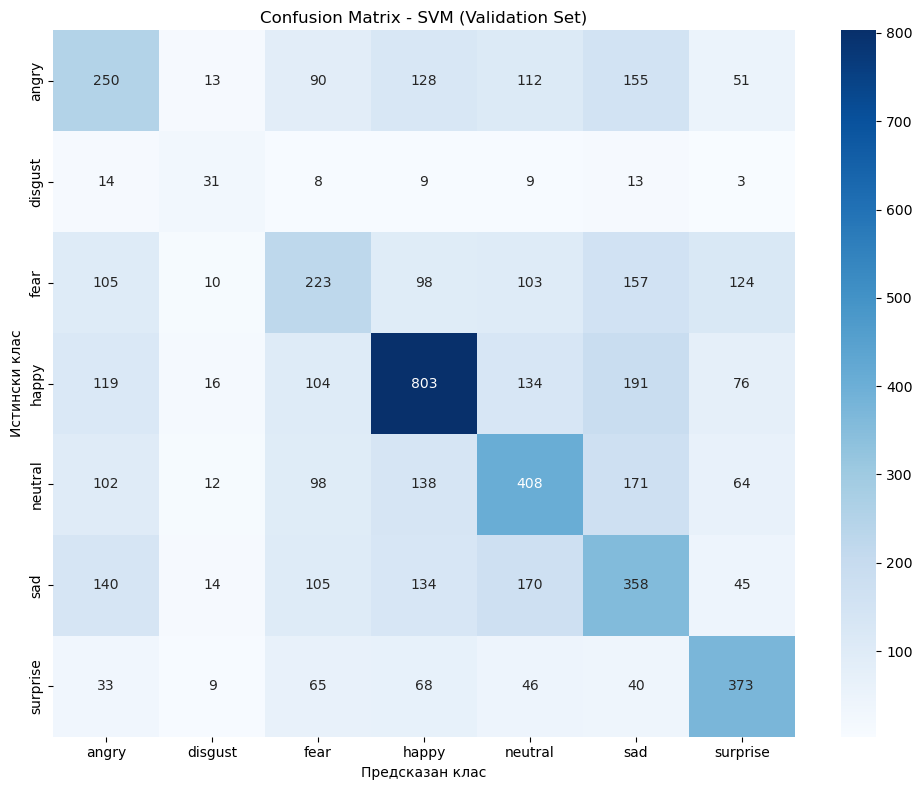

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title(f'Confusion Matrix - {best_model_name} (Validation Set)')
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.tight_layout()
plt.show()

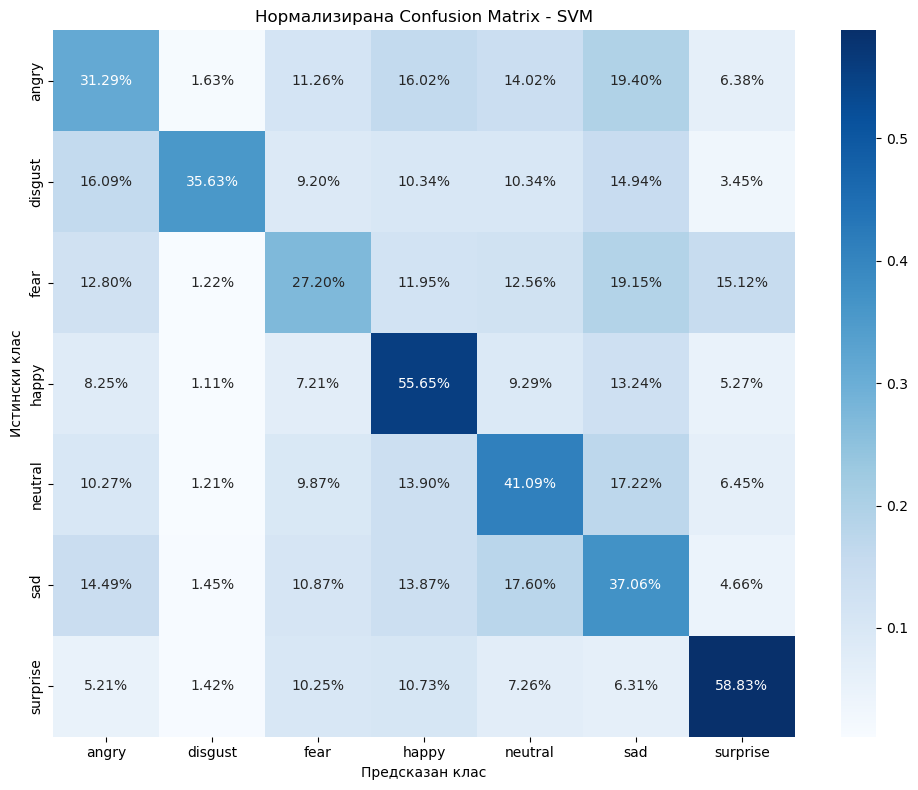

In [16]:
# Нормализирана Confusion Matrix (в проценти)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title(f'Нормализирана Confusion Matrix - {best_model_name}')
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.tight_layout()
plt.show()

### Изводи от детайлния анализ

**Recall по класове (диагонала на confusion matrix):**

> **Recall** = TP / (TP + FN) = "От всички истински X, колко успяхме да открием?"

| Емоция | Recall | Оценка |
|--------|--------|--------|
| **Surprise** | 58.8% | Най-добър |
| **Happy** | 55.6% | Много добър |
| **Neutral** | 41.1% | Среден |
| **Sad** | 37.1% | Среден |
| **Disgust** | 35.6% | Слаб |
| **Angry** | 31.3% | Слаб |
| **Fear** | 27.2% | Най-лош |

**Най-чести грешки (високи стойности извън диагонала):**

| Истински клас | Грешно предсказан като | Процент | Защо? |
|---------------|------------------------|---------|-------|
| Angry → | Sad | 19.4% | Свъсени вежди, напрегнато лице |
| Fear → | Sad | 19.1% | Сходна негативна експресия |
| Sad → | Neutral | 17.6% | Липса на силна експресия |
| Neutral → | Sad | 17.2% | Двупосочна връзка - трудни за разграничаване |
| Angry → | Happy | 16.0% | Може би показване на зъби |
| Fear → | Surprise | 15.1% | Отворени очи и уста |

**Ключови наблюдения:**

1. **Surprise и Happy се разпознават най-добре** - имат уникални, ясно изразени features (усмивка, отворена уста)

2. **Fear е най-труден за разпознаване (27.2% recall)** - често се бърка със sad, surprise и angry. Това означава, че 72.8% от fear изображенията се класифицират грешно!

3. **Sad ↔ Neutral са взаимно объркващи** - липсата на силна експресия ги прави сходни

4. **Disgust се представя по-добре от очакваното (35.6%)** - въпреки малкото примери, class weights помагат

## 9. Финална оценка на Test Set

Test set използваме само веднъж - за финална оценка!

In [19]:
print(f"Финална оценка на {best_model_name} върху TEST set:")
print("=" * 50)

# Предсказания на test set
y_test_pred = best_model.predict(X_test_flat)

# Метрики
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test F1-Score (weighted): {test_f1:.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=EMOTIONS))

Финална оценка на SVM върху TEST set:
Test Accuracy: 0.4289 (42.89%)
Test F1-Score (weighted): 0.4278

Classification Report:
              precision    recall  f1-score   support

       angry       0.31      0.29      0.30       958
     disgust       0.40      0.46      0.43       111
        fear       0.31      0.27      0.29      1024
       happy       0.59      0.55      0.57      1774
     neutral       0.40      0.42      0.41      1233
         sad       0.35      0.38      0.37      1247
    surprise       0.54      0.61      0.57       831

    accuracy                           0.43      7178
   macro avg       0.41      0.43      0.42      7178
weighted avg       0.43      0.43      0.43      7178



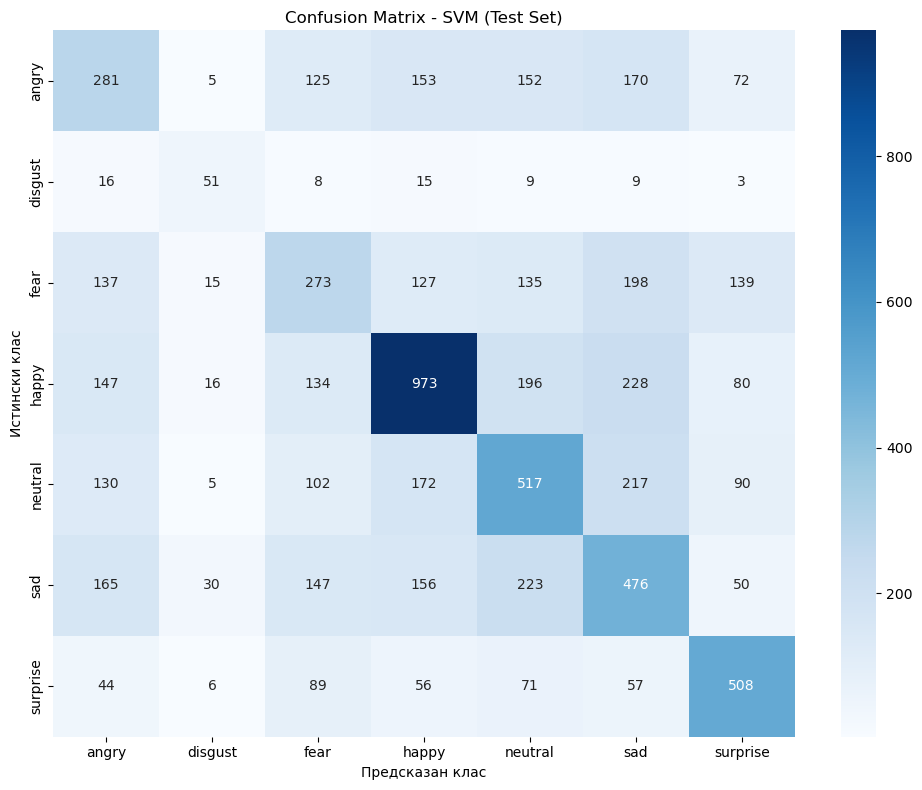

In [20]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.tight_layout()
plt.show()

### Анализ на Test Set резултатите

**Сравнение Validation vs Test (Recall по клас):**

> **Recall** = "От всички истински примери на този клас, колко процента открихме правилно?"

| Емоция | Val Recall | Test Recall | Промяна |
|--------|------------|-------------|---------|
| Surprise | 58.8% | **61.1%** | +2.3% |
| Happy | 55.6% | 54.8% | -0.8% |
| Disgust | 35.6% | **45.9%** | +10.3% |
| Neutral | 41.1% | 41.9% | +0.8% |
| Sad | 37.1% | 38.2% | +1.1% |
| Angry | 31.3% | 29.3% | -2.0% |
| Fear | 27.2% | 26.7% | -0.5% |

**Ключови наблюдения:**

1. **Резултатите са стабилни** - повечето класове имат сходен recall между validation и test, което означава, че моделът не е overfitted.

2. **Disgust се подобри значително (+10.3%)** - вероятно test set-ът има по-типични примери за тази емоция.

3. **Surprise остава най-добър (61.1% recall)** - ясно изразените features (отворена уста, повдигнати вежди) се разпознават добре.

4. **Fear остава най-труден (26.7% recall)** - почти 3/4 от fear изображенията се класифицират грешно.

5. **Основни грешки са същите:**
   - Fear → Sad (19.3%)
   - Sad → Neutral (17.9%)
   - Angry → Sad (17.7%)

**Заключение:** Baseline моделът (SVM) постига **~42-43% overall accuracy** на test set. Това е солидна база за сравнение с CNN модела, който очакваме да постигне **60-70% accuracy** благодарение на способността си да улавя пространствени features.

## 10. Запазване на модела

In [22]:
# Създаване на директория за модели
os.makedirs('../models', exist_ok=True)

# Запазване на двата модела
joblib.dump(svm_model, '../models/svm_baseline.joblib')
joblib.dump(rf_model, '../models/rf_baseline.joblib')

print("Моделите са запазени:")
print("  - ../models/svm_baseline.joblib")
print("  - ../models/rf_baseline.joblib")

Моделите са запазени:
  - ../models/svm_baseline.joblib
  - ../models/rf_baseline.joblib


## 11. Обобщение

### Резултати

In [23]:
print("=" * 60)
print("ОБОБЩЕНИЕ НА BASELINE МОДЕЛИТЕ")
print("=" * 60)
print()
print(f"По-добър модел: {best_model_name}")
print()
print("Validation резултати:")
print(f"  - SVM:           Accuracy={svm_val_accuracy:.4f}, F1={svm_val_f1:.4f}")
print(f"  - Random Forest: Accuracy={rf_val_accuracy:.4f}, F1={rf_val_f1:.4f}")
print()
print(f"Test резултати ({best_model_name}):")
print(f"  - Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - F1-Score: {test_f1:.4f}")
print()
print("=" * 60)

ОБОБЩЕНИЕ НА BASELINE МОДЕЛИТЕ

По-добър модел: SVM

Validation резултати:
  - SVM:           Accuracy=0.4260, F1=0.4249
  - Random Forest: Accuracy=0.4383, F1=0.4140

Test резултати (SVM):
  - Accuracy: 0.4289 (42.89%)
  - F1-Score: 0.4278



### Наблюдения

1. **Ограничения на класическите модели:**
   - Flatten превръща 2D изображение в 1D вектор
   - Губим пространствената информация (кой пиксел до кой е)
   - Не се отчитат локални pattern-и (очи, уста, вежди)

2. **Защо CNN би бил по-добър:**
   - Конволюционните слоеве запазват пространствената структура
   - Извличат локални features (ръбове, текстури)
   - Йерархично комбиниране на features

### Следваща стъпка

В следващия notebook (`04_cnn_model.ipynb`) ще:
1. Построим CNN архитектура
2. Обучим с data augmentation
3. Сравним резултатите с baseline